# Laboratorio 6 - Tráfico

#### 20880 Sebastian Aristondo
#### 20293 Daniel Gonzalez

## 2. Carga de datos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.corpus import opinion_lexicon
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
import datetime
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from langdetect import detect
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\Daniel\Main\UVG\Semestre VIII\Data science\Lab6_DS\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('traficogt.csv', sep=',')
data.head()

,number,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,...,quotedTweet,place,coordinates,inReplyToTweetId,inReplyToUser,source,sourceUrl,sourceLabel,media,_type
0,0,1701654244858679742,1701654244858679742,https://twitter.com/EmisorasUnidas/status/1701...,2023-09-12 17:49:21+00:00,"{'id': 40256008, 'id_str': '40256008', 'url': ...",es,"#AHORA Amílcar Montejo, director de Comunicaci...",1,2,...,"{'id': 1701651855212691764, 'id_str': '1701651...",NaN,NaN,NaN,NaN,"<a href=""https://twitter.com"" rel=""nofollow"">T...",https://twitter.com,TweetDeck Web App,"{'photos': [], 'videos': [], 'animated': []}",snscrape.modules.twitter.Tweet
1,1,1701651855212691764,1701651855212691764,https://twitter.com/amilcarmontejo/status/1701...,2023-09-12 17:39:52+00:00,"{'id': 372126670, 'id_str': '372126670', 'url'...",es,CONDUCTORA QUE SE NEGÓ A MOVILIZAR VEHÍCULO ES...,149,78,...,NaN,NaN,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,{'photos': [{'url': 'https://pbs.twimg.com/med...,snscrape.modules.twitter.Tweet
2,2,1701348453916311903,1701348453916311903,https://twitter.com/edgarduarteagui/status/170...,2023-09-11 21:34:15+00:00,"{'id': 100815432, 'id_str': '100815432', 'url'...",es,Camión de arena volteado en el viaducto el pul...,2,1,...,NaN,NaN,NaN,NaN,NaN,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",snscrape.modules.twitter.Tweet
3,3,1701995859229958189,1701995859229958189,https://twitter.com/DrDavidCabrera/status/1701...,2023-09-13 16:26:49+00:00,"{'id': 743252657083650048, 'id_str': '74325265...",es,"Paciente de 39 años, dolor lumbar de 1 año tra...",3,17,...,NaN,NaN,NaN,NaN,NaN,"<a href=""https://help.twitter.com/en/using-twi...",https://help.twitter.com/en/using-twitter/how-...,advertiser-interface,{'photos': [{'url': 'https://pbs.twimg.com/med...,snscrape.modules.twitter.Tweet
4,4,1701216420997017888,1701216420997017888,https://twitter.com/EmisorasUnidas/status/1701...,2023-09-11 12:49:36+00:00,"{'id': 40256008, 'id_str': '40256008', 'url': ...",es,"#AHORA Amílcar Montejo, director de Comunicaci...",0,0,...,NaN,NaN,NaN,NaN,NaN,"<a href=""https://twitter.com"" rel=""nofollow"">T...",https://twitter.com,TweetDeck Web App,{'photos': [{'url': 'https://pbs.twimg.com/med...,snscrape.modules.twitter.Tweet


## 3. Limpieza y preprocesamiento de datos

El dataset tiene los datos crudos, por lo que debemos de limpiarlos y preprocesarlos para poder trabajar con ellos. Para esto, se utilizo la libreria pandas para poder leer el archivo csv y poder trabajar con el. Luego utilizaremos varias funciones de nltk para poder limpiar los datos y dejarlos listos para poder trabajar con ellos.

In [3]:
def remove_urls(rawContent):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return re.sub(url_pattern, '', rawContent)

Se realizaron tres acciones iniciales para limpiar y preprocesar datos. Primero se eliminó cualquier URL de los datos usando una expresión regular. También se mantuvieron solamente los caracteres que estuvieran de la a a la z, mayúsculas o minúsculas. Esto quiere decir que se quitó cualquier caracter como "#" o "@" y signos de puntuación. Por otra parte, se pasaron todas las palabras a minúsculas.

In [4]:
def remove_tildes(rawContent):
    rawContent = rawContent.replace('á', 'a')
    rawContent = rawContent.replace('é', 'e')
    rawContent = rawContent.replace('í', 'i')
    rawContent = rawContent.replace('ó', 'o')
    rawContent = rawContent.replace('ú', 'u')
    return rawContent

In [5]:
data['rawContent'] = data['rawContent'].apply(remove_urls)
data['rawContent'] = data['rawContent'].apply(lambda x: x.lower())
data['rawContent'] = data['rawContent'].apply(remove_tildes)

In [6]:
data['rawContent'] = data['rawContent'].str.replace('[^a-zA-Z0-9]', ' ', regex=True)

Se removieron URLS y se quitaron caracteres especiales. También se pasaron todos los tweets a minúsculas y se removieron las tildes, para poder tener una forma estandarizada de los símbolos de los tweets en el dataset.

In [7]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('spanish'))  
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    new_sentence = ' '.join(filtered_words)
    return new_sentence

data['rawContent_clean'] = data['rawContent'].apply(remove_stop_words)

Se eliminaron las stop words en español que pudiera tener el dataset.

In [8]:
data['rawContent_clean'].head()

0    ahora amilcar montejo director comunicacion em...
1    conductora nego movilizar vehiculo multada cal...
2    camion arena volteado viaducto pulte hacia hac...
3    paciente 39 dolor lumbar 1 tras caida hizo 45 ...
4    ahora amilcar montejo director comunicacion em...
Name: rawContent_clean, dtype: object

In [9]:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

data['rawContent_lemmatized'] = data['rawContent_clean'].apply(lambda x: lemmatize_words(x.split()))
data['rawContent_lemmatized_text'] = data['rawContent_lemmatized'].apply(lambda x: ' '.join(x))

Con el objetivo de analizar de una manera más sencilla los tweets los lematizaremos para poder obtener palabras clave como zona y lluvia.


In [10]:
data['rawContent_lemmatized'].head()

0    [ahora, amilcar, montejo, director, comunicaci...
1    [conductora, nego, movilizar, vehiculo, multad...
2    [camion, arena, volteado, viaducto, pulte, hac...
3    [paciente, 39, dolor, lumbar, 1, tras, caida, ...
4    [ahora, amilcar, montejo, director, comunicaci...
Name: rawContent_lemmatized, dtype: object

In [11]:
data['rawContent_lemmatized_text'].head()

0    ahora amilcar montejo director comunicacion em...
1    conductora nego movilizar vehiculo multada cal...
2    camion arena volteado viaducto pulte hacia hac...
3    paciente 39 dolor lumbar 1 tras caida hizo 45 ...
4    ahora amilcar montejo director comunicacion em...
Name: rawContent_lemmatized_text, dtype: object

In [12]:
data = data.drop("number", axis=1)   

In [13]:
def delete_non_spanish_tweets(texto):
    try:
        return detect(texto) == 'es'
    except:
        # Si no se puede detectar el idioma, se asume que no es español
        return False

In [14]:
data = data[data['rawContent'].apply(delete_non_spanish_tweets)]

## 4. Análisis exploratorio

In [15]:
data.shape

(11247, 31)

In [16]:
data.columns

Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'hashtags', 'cashtags', 'mentionedUsers', 'links',
       'viewCount', 'retweetedTweet', 'quotedTweet', 'place', 'coordinates',
       'inReplyToTweetId', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', '_type', 'rawContent_clean',
       'rawContent_lemmatized', 'rawContent_lemmatized_text'],
      dtype='object')

In [17]:
nas_coordenadas = data['coordinates'].isna().sum()
print('Porcentaje de tweets sin coordenadas: ', nas_coordenadas/data.shape[0]*100)

print("Cantidad de tweets con coordenadas: ", data.shape[0] - nas_coordenadas)


Porcentaje de tweets sin coordenadas:  99.98221748021695
Cantidad de tweets con coordenadas:  2


Como se puede observar, casi todos los tweets no tienen coordenadas, por lo tanto, no es posible realizar un análisis de tweets por ubicación para determinar que áreas tienen más tráfico.

In [18]:
coincidencias = []

# Utilizar expresiones regulares para encontrar coincidencias de "zona" seguida de un número
pattern = r'\bzona\s+(\d+)\b'  # \b asegura que "zona" sea una palabra completa, \s+ coincide con uno o más espacios, \d+ coincide con uno o más dígitos

# Buscar coincidencias en la columna 'texto' y almacenarlas en la lista
for texto in data['rawContent_clean']:
    matches = re.findall(pattern, texto)
    coincidencias.extend(matches)

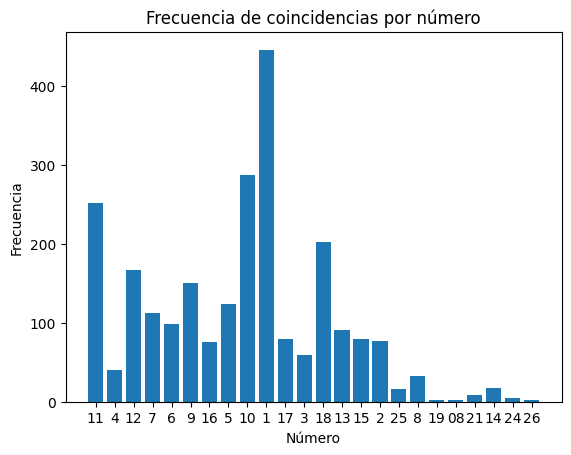

In [19]:
# Contar la frecuencia de cada número
conteo_coincidencias = Counter(coincidencias)

# Obtener las etiquetas (números) y sus frecuencias
etiquetas = list(conteo_coincidencias.keys())
frecuencias = list(conteo_coincidencias.values())

# Crear el gráfico de barras
plt.bar(etiquetas, frecuencias)

# Agregar etiquetas y título
plt.xlabel('Número')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de coincidencias por número')

# Mostrar el gráfico
plt.show()

Se puede observar que de los tweets relacionados al tráfico, la mayor cantidad vienen de zona 1, zona 10, zona 11 y zona 18. 

In [20]:
usuarios = data['user'].unique()
print('Cantidad de usuarios unicos en el dataset: ', len(usuarios))

Cantidad de usuarios unicos en el dataset:  4309


In [21]:
def extraer_valor(diccionario):
    diccionario = eval(diccionario)
    return diccionario["username"]

data["username"]=data["user"].apply(extraer_valor)


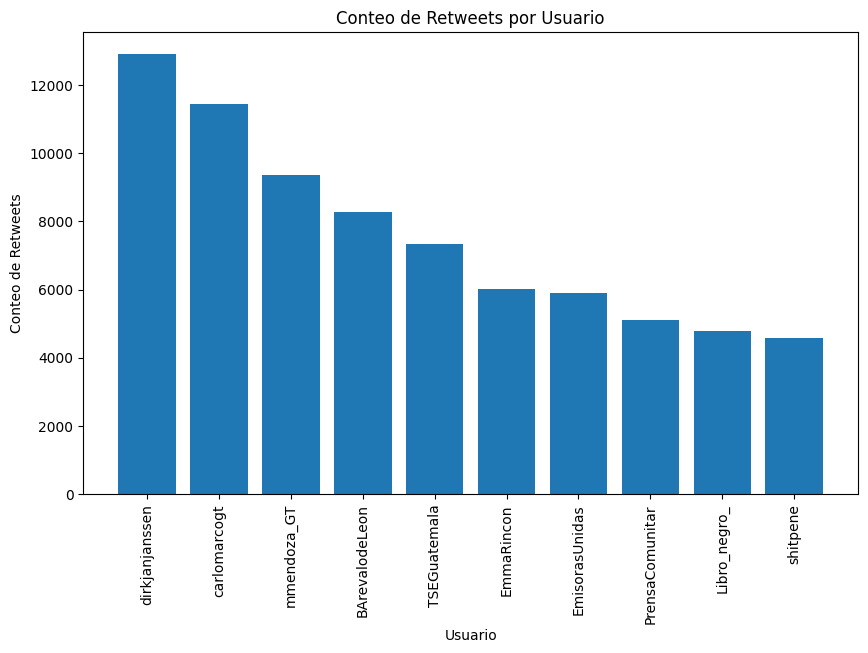

In [22]:
tweets_mas_rt = data.groupby('username')['retweetCount'].sum()
tr_count_df = tweets_mas_rt.reset_index()
tr_count_df = tr_count_df.rename(columns={'retweetCount': 'count'})
tr_count_df = tr_count_df.sort_values(by='count', ascending=False)
tr_count_df = tr_count_df.head(10)

plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.bar(tr_count_df['username'], tr_count_df['count'])
plt.xlabel('Usuario')
plt.ylabel('Conteo de Retweets')
plt.title('Conteo de Retweets por Usuario')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()


In [23]:
print(f"Como podemos ver el usuario {tr_count_df.iloc[0]['username']} pareciera ser un usuario muy activo en Twitter en cuanto a tweets \nrelacionados al tráfico. Mucha gente comparte la información que el público. Este hallazgo es interesante ya que asumimos \nque el mayor referente sobre este rubro sería prensa libre, Amílcar Montejo o algún otro medio de comunicación.")


Como podemos ver el usuario dirkjanjanssen pareciera ser un usuario muy activo en Twitter en cuanto a tweets 
relacionados al tráfico. Mucha gente comparte la información que el público. Este hallazgo es interesante ya que asumimos 
que el mayor referente sobre este rubro sería prensa libre, Amílcar Montejo o algún otro medio de comunicación.


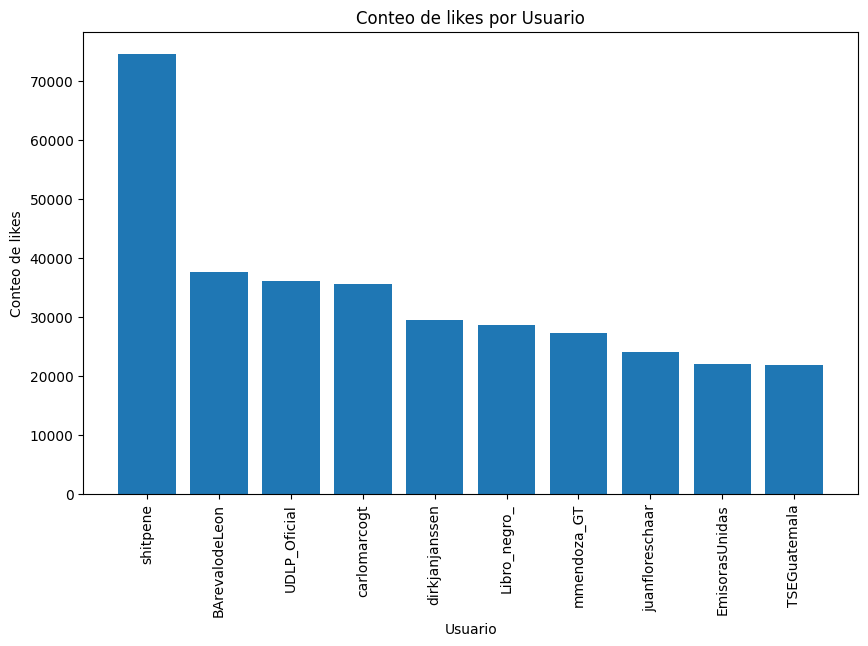

In [24]:
tweets_mas_likes = data.groupby('username')['likeCount'].sum()
tr_count_df_likes = tweets_mas_likes.reset_index()
tr_count_df_likes = tr_count_df_likes.rename(columns={'likeCount': 'count'})
tr_count_df_likes = tr_count_df_likes.sort_values(by='count', ascending=False)
tr_count_df_likes = tr_count_df_likes.head(10)

plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.bar(tr_count_df_likes['username'], tr_count_df_likes['count'])
plt.xlabel('Usuario')
plt.ylabel('Conteo de likes')
plt.title('Conteo de likes por Usuario')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()

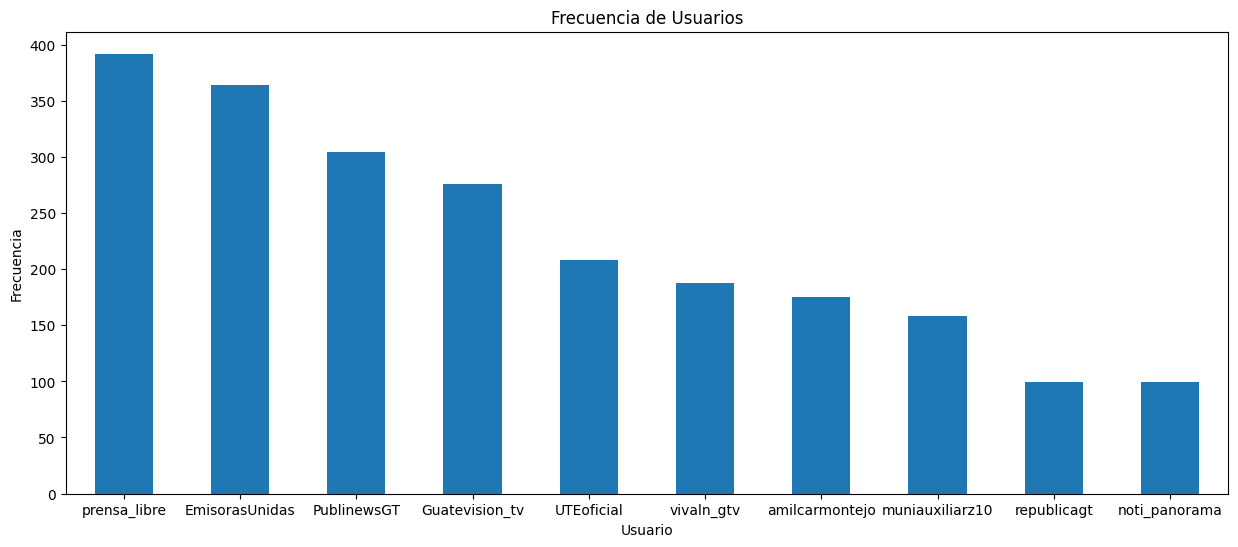

In [25]:
frecuencia_usuarios = data['username'].value_counts()

usuarios_ordenados = frecuencia_usuarios.sort_values(ascending=False)

# Tomar los 10 usuarios más frecuentes
top_10_usuarios = usuarios_ordenados.head(10)

# Crear un gráfico de barras
plt.figure(figsize=(15, 6))  # Tamaño del gráfico
top_10_usuarios.plot(kind='bar')
plt.xlabel('Usuario')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Usuarios')
plt.xticks(rotation=0)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()

In [26]:
# Cargar el modelo pre-entrenado de BERT para análisis de sentimiento
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Crear una función para realizar análisis de sentimiento
def analyze_sentiment(text):
    # Tokenizar el texto y obtener la salida del modelo
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)

    # Obtener la predicción de sentimiento
    prediction = torch.argmax(outputs.logits, dim=1).item()
    
    # Definir la escala de sentimiento
    sentiment_scale = {
        0: 'Muy negativo',
        1: 'Negativo',
        2: 'Neutral',
        3: 'Positivo',
        4: 'Muy positivo'
    }
    
    # Obtener la etiqueta de sentimiento
    sentiment_label = sentiment_scale[prediction]
    
    return sentiment_label


In [27]:
def verificar_sentimiento(dataframe, columna):

    for valor in dataframe[columna]:
        filas = data[data['username'] == valor]
        result = filas['rawContent_clean'].apply(analyze_sentiment)
        frecuencia_valores = result.value_counts()
        valor_mas_comun = frecuencia_valores.idxmax()
        print("Los tweets del usuario ", valor, " son mayormente ", valor_mas_comun)
    

In [28]:
print("Los sentimientos de los tweets de los usuarios que tienen más retweets son:")
verificar_sentimiento(tr_count_df, "username")

Los sentimientos de los tweets de los usuarios que tienen más retweets son:
Los tweets del usuario  dirkjanjanssen  son mayormente  Neutral
Los tweets del usuario  carlomarcogt  son mayormente  Muy negativo
Los tweets del usuario  mmendoza_GT  son mayormente  Muy negativo
Los tweets del usuario  BArevalodeLeon  son mayormente  Muy negativo
Los tweets del usuario  TSEGuatemala  son mayormente  Positivo
Los tweets del usuario  EmmaRincon  son mayormente  Muy negativo
Los tweets del usuario  EmisorasUnidas  son mayormente  Muy negativo
Los tweets del usuario  PrensaComunitar  son mayormente  Muy negativo
Los tweets del usuario  Libro_negro_  son mayormente  Muy negativo
Los tweets del usuario  shitpene  son mayormente  Muy negativo


In [29]:
print("Los sentimientos de los tweets de los usuarios que tienen más likes son:")
verificar_sentimiento(tr_count_df_likes, "username")

Los sentimientos de los tweets de los usuarios que tienen más likes son:
Los tweets del usuario  shitpene  son mayormente  Muy negativo
Los tweets del usuario  BArevalodeLeon  son mayormente  Muy negativo
Los tweets del usuario  UDLP_Oficial  son mayormente  Muy negativo
Los tweets del usuario  carlomarcogt  son mayormente  Muy negativo
Los tweets del usuario  dirkjanjanssen  son mayormente  Neutral
Los tweets del usuario  Libro_negro_  son mayormente  Muy negativo
Los tweets del usuario  mmendoza_GT  son mayormente  Muy negativo
Los tweets del usuario  juanfloreschaar  son mayormente  Negativo
Los tweets del usuario  EmisorasUnidas  son mayormente  Muy negativo
Los tweets del usuario  TSEGuatemala  son mayormente  Positivo


Al realizar un análisis de sentimiento, se puede observar que la mayoría de los influencers encontrados, es decir, aquellos que tienen muchos retweets y likes, tienen un contenido muy negativo.

In [30]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [31]:
def verificar_sentimiento_tweet(tweets):
    sentiments = []
    for valor in tweets:
        result = analyze_sentiment(valor)
        sentiments.append(result)
    
    # Obtener la frecuencia de cada sentimiento
    frecuencia_sentimientos = Counter(sentiments)
    
    # Extrae las etiquetas de sentimientos y las frecuencias
    etiquetas = frecuencia_sentimientos.keys()
    frecuencias = frecuencia_sentimientos.values()

    # Crea el gráfico de barras
    plt.bar(etiquetas, frecuencias)

    # Añade etiquetas y título
    plt.xlabel('Sentimientos')
    plt.ylabel('Frecuencia')
    plt.title('Frecuencia de Sentimientos')

    # Muestra el gráfico
    plt.show()

In [32]:
def get_palabras_repetidas(tweets):
    # Obtener todas las palabras
    all_words = []
    for tweet in tweets:
        words = tweet.split()
        all_words.extend(words)

    # Obtener las palabras más repetidas
    frecuencia_palabras = Counter(all_words)
    generate_wordcloud(' '.join(all_words))

In [33]:
palabras = ['calzada la paz', 'zona 5', 'hundimiento', 'caverna', 'boulevard lourdes', 'boulevard austriaco', 'socavon']
patron = '|'.join(palabras)
resultados = data[data['rawContent_lemmatized_text'].str.contains(patron, case=False, na=False)]['rawContent_lemmatized_text']
resultados.shape

(143,)

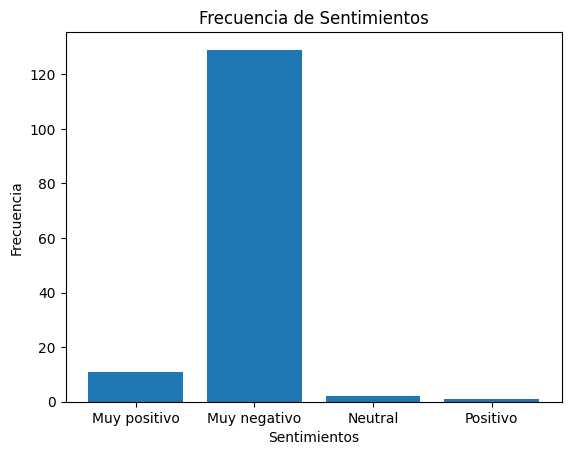

In [34]:
verificar_sentimiento_tweet(resultados)

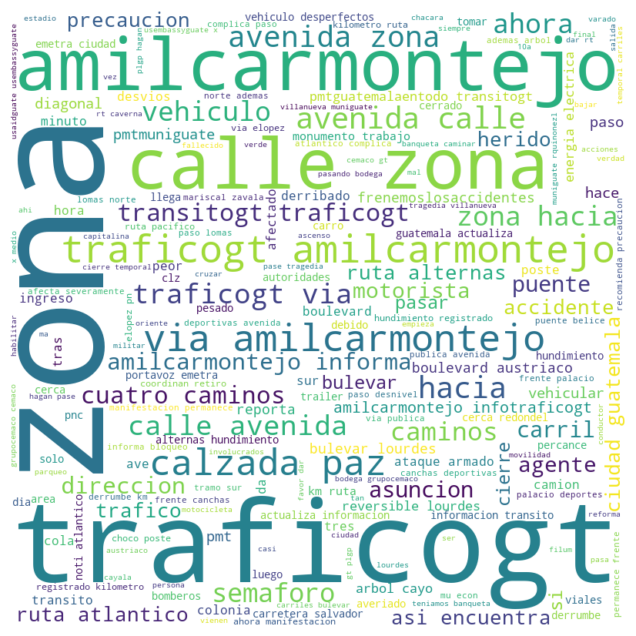

In [35]:
get_palabras_repetidas(resultados)

In [36]:
palabras_socavon = ['socavon', 'calzada la paz']
patron_socavon = '|'.join(palabras)
resultados_socavon = data[data['rawContent_lemmatized_text'].str.contains(patron_socavon, case=False, na=False)]['rawContent_lemmatized_text']

palabras_uvg = ['uvg', 'universidad del valle', 'url', 'universidad rafael landivar', 'boulevard austriaco']
patron_uvg = '|'.join(palabras_uvg)
resultados_uvg = data[data['rawContent_lemmatized_text'].str.contains(patron_uvg, case=False, na=False)]['rawContent_lemmatized_text']

resultados_socavon = set(resultados_socavon)
resultados_uvg = set(resultados_uvg)

interseccion = resultados_socavon.intersection(resultados_uvg)
lista = list(interseccion)
print("La cantidad de tweets que involucran a la UVG y alrededores y al socavón es de: ", len(lista))

La cantidad de tweets que involucran a la UVG y alrededores y al socavón es de:  3


In [37]:
palabras_lluvia = ['lluvia', 'lluvioso', 'derrumbe', 'derrumbes', 'rio', 'rios', 'desbordado', 'desbordamiento']
patron_lluvia = '|'.join(palabras)

df_lluvia = data[data['rawContent'].str.contains(patron_lluvia, case=False)]
res_lluvia = df_lluvia['rawContent_lemmatized_text']

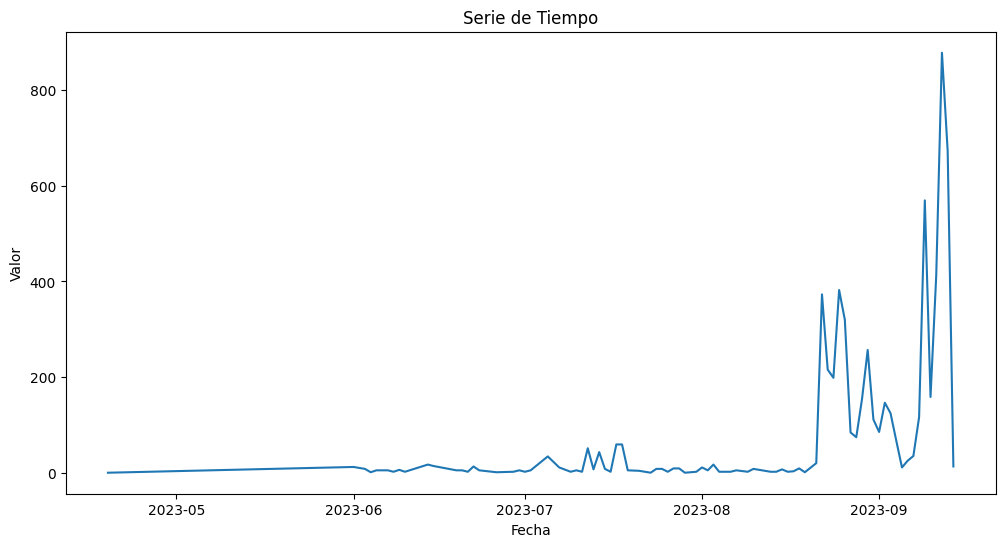

In [38]:
data['date'] = pd.to_datetime(data['date'])

fechas_lluvia = data['date'].dt.date
frecuencia_lluvia = fechas_lluvia.value_counts().sort_index()
fecha_inicio = pd.to_datetime('2023-01-01').date()
frecuencia_lluvia_filtrada = frecuencia_lluvia[fecha_inicio:]

# Crear el gráfico de serie de tiempo
frecuencia_lluvia_filtrada.plot(figsize=(12, 6))
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie de Tiempo')
plt.show()

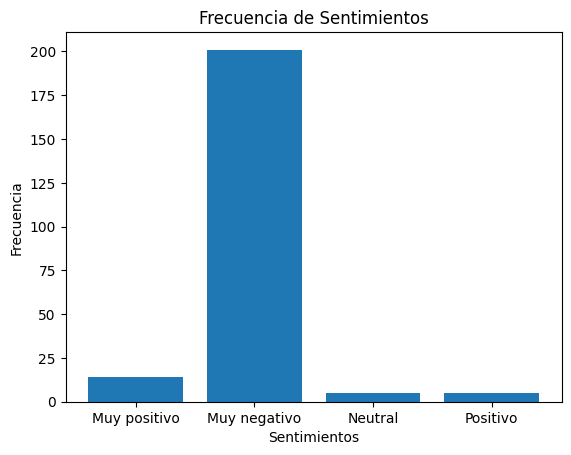

In [39]:
verificar_sentimiento_tweet(res_lluvia)

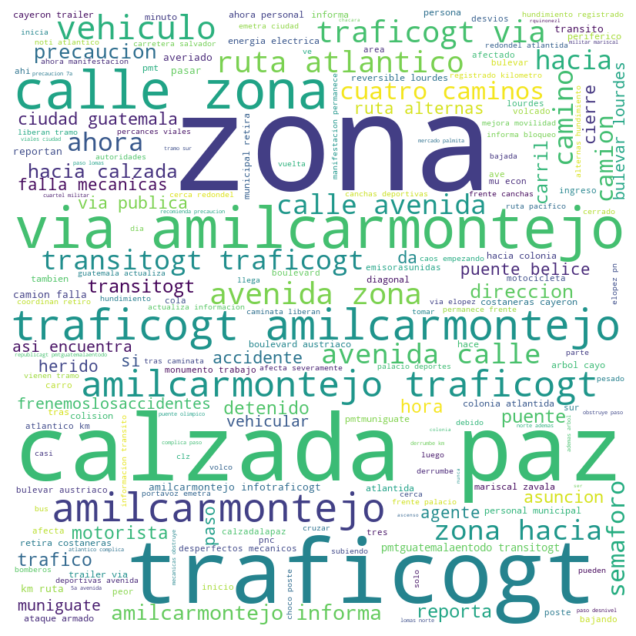

In [40]:
get_palabras_repetidas(res_lluvia)

## 5. Descubrimientos

Se encontró que la mayoría de tweets de tránsito provienen de zona 1, un área donde muchas veces se da mucho tráfico y percances viales. También bastantes tweets vienen de zona 10, donde igualmente se da mucho tráfico, especialmente en las tardes, por ser un área laboral grande. También en zona 18, 11 y 9 se dan muchos tweets.

Tweets fuera del contexto:
Al comenzar con nuestro análisis exploratorio comenzamos a buscar que usuario era el que más tweets había hecho, y nos encontramos con varios usuarios que no eran medios de comunicación. Esto nos dio curiosidad por lo que lo buscamos los usuarios en twitter. Al buscarlos nos llevamos la sorpresa que era gente de Holanda, Suiza, Las Maldivas. Esto nos hizo pensar que el dataset no contenia unicamente tweets de Guatemala, por lo tanto aplicamos nuevas técnicas para poder encontrar los tweets que no eran de Guatemala. Dado que el dataset no cuenta con coordenadas unicamente pudimos aplicar algunos filtros en base al idioma.

Influencers inesperados:
Queríamos encontrar que usuario era el que más impacto tenía al publicar, por lo tanto sumamos todos los retweets y likes de cada usuario. Nos encontramos con que el usuario que más impacto tenía era un usuario holandes que publicaba en español. Lastimosamente utilizaba hashtags relacionados con el tráfico, por lo que no pudimos filtrarlo.

Influencers conocidos:
Dado que los usuarios que más interacciones tuvieron nos llevaron a usuarios fuera del estudio, decidimos ahora enforcarnos en los usuarios que más publicaban. Al realizar esta tabla de frecuencia obtuvimos que los usuarios que más publicaban eran medios de comunicación, lo cual era esperado.Entre los usuarios que más publican están PublinewsGT, EmisorasUnidas, AmilcarMontejo, etc.

Socavón zona 5:
El socavón de la zona 5 tuvo distintos resultados interesantes. Se puede observar que las palabras más repetidas se refieren a Amilcar Montejo, que es el vocero de tránsito de la ciudad de Guatemala. También se observa que se habla de tráfico, carril auxiliar y reversible cerca la colonia Lourdes en zona 16, búsqueda de vías alternas, cierres y del boulevard Austriaco. Esto indica que los tweets principalmente hablan del socavón y de las alternativas que se están tomando para poder solucionar el problema, así como los inconvenientes que este causa. También se puede observar que todos el sentimiento que predomina en los tweets relacionados es muy negativo, lo cual indica que está causando muchos problemas. Con respecto a la UVG y sus alrededores, se puede observar que solo existen 3 tweets, por lo que no hay mucha información sobre los inconvenientes que puede causar el socavón en la UVG.

El tráfico y la lluvia:
De la serie de tiempo realizada, se puede observar que hubo un aumento significativo de los tweets relacionados con lluvia a mediados del mes de agosto, continuando a septiembre. La mayoría de los tweets relacionados con lluvia tienen un sentimiento negativo, lo cual indica que está causando problemas. Las palabras que más se repiten en los tweets son relacionadas a accidentes y tráfico, lo cual indica que la lluvia está causando perfcances en el tráfico. Es interesante ver que los tweets están un poco sesgados, puesto que hay varios que hablan de regiones en zona 16, 15 y 17. Esto puede estar relacionado al socavón de zona 5.

## 6. Conclusiones

Se puede concluir que la mayoría de tweets relacionados al tráfico tienen un sentimiento muy negativo, especialmente por todos los accidentes y problemas que se reportan. La mayoría de influencers que están relacionados al tema, generan contenido negativo y estos tienen muchos retweets y likes. Esto indica que el tráfico es un problema que afecta a muchas personas y que es un tema que genera mucha interacción en redes sociales. También se puede concluir que no se tiene suficiente información para saber si el socavón de zona 5 ha afectado a la UVG, sin embargo, se tienen tweets relacionados al boulevard Austriaco, Cayala y Calzada la Paz, las cuales son zonas aledañas a la universidad, por lo que puede que si afecte el tráfico. La mayoría de tweets relacionados al sovacón son muy negativos. Por otra parte, la lluvia ha afectado mucho al tránsito. Esto se evidencia en un aumento significativo de tweets relacionados a lluvia en el último mes, además de que son negativos y se reportan accidentes y problemas relacionados.